<a href="https://colab.research.google.com/github/haeeeeuni/Deeplearning_assignments/blob/main/%08Deeplearning_assignment1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 문제1

 Lab 0 Broadcasting: Multiply a tensor by a set of constants에서
multiplication 예제를 addition으로 수정하세요.

In [26]:
#addition example
import torch
x = torch.tensor([[1, 2, 3], [4, 5, 6]])  # x has shape (2, 3)
c = torch.tensor([1, 10, 11, 100])        # c has shape (4)
print('Here is the matrix:')
print(x)
print('\nHere is the vector:')
print(c)
y = c.view(-1, 1, 1) + x    #c.view(-1,1,1)의 결과: (4,1,1)의 3차원 벡터가 된다
print('\nAdd x by a set of constants:')
print(y)

Here is the matrix:
tensor([[1, 2, 3],
        [4, 5, 6]])

Here is the vector:
tensor([  1,  10,  11, 100])

Add x by a set of constants:
tensor([[[  2,   3,   4],
         [  5,   6,   7]],

        [[ 11,  12,  13],
         [ 14,  15,  16]],

        [[ 12,  13,  14],
         [ 15,  16,  17]],

        [[101, 102, 103],
         [104, 105, 106]]])


# 문제2

 Lab 1 Universal Approximation Theorem에서 L2대신 L1 regularization으로
학습시키고 결과를 비교 논의하세요.

In [20]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Data generation
x = torch.linspace(-np.pi, np.pi, 200).view(-1, 1)

# Original neural network definition for reference
class Net(nn.Module):
    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, hidden_size)  # Input to hidden layer
        self.fc2 = nn.Linear(hidden_size, 1)  # Hidden to output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Modified neural network definition for activation extraction
class NetWithActivations(Net):
    def __init__(self, hidden_size):
        super(NetWithActivations, self).__init__(hidden_size)

    def forward_with_activations(self, x):
        activations = torch.relu(self.fc1(x))
        output = self.fc2(activations)
        return output, activations

In [21]:
# Training setup
model = NetWithActivations(hidden_size=50)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [26]:
def train_model_with_regularization(model, criterion, optimizer, x, y, epochs=2000, weight_decay=0):
    lm = 0.0001
    for epoch in range(epochs):
        y_pred = model(x)
        loss = criterion(y_pred, y)
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss = loss + lm * l1_norm
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [27]:
# Model without regularization
y = torch.sin(x)
model_no_reg = NetWithActivations(hidden_size=50)
optimizer_no_reg = torch.optim.Adam(model_no_reg.parameters(), lr=0.01)
train_model_with_regularization(model_no_reg, criterion, optimizer_no_reg, x, y, epochs=2000, weight_decay=0)

# Model with regularization
model_with_reg = NetWithActivations(hidden_size=50)
optimizer_with_reg = torch.optim.Adam(model_with_reg.parameters(), lr=0.01, weight_decay=0.01)  # Including L2 regularization
train_model_with_regularization(model_with_reg, criterion, optimizer_with_reg, x, y, epochs=2000, weight_decay=0.01)


Epoch [100/2000], Loss: 0.0066
Epoch [200/2000], Loss: 0.0056
Epoch [300/2000], Loss: 0.0053
Epoch [400/2000], Loss: 0.0052
Epoch [500/2000], Loss: 0.0050
Epoch [600/2000], Loss: 0.0048
Epoch [700/2000], Loss: 0.0047
Epoch [800/2000], Loss: 0.0045
Epoch [900/2000], Loss: 0.0043
Epoch [1000/2000], Loss: 0.0041
Epoch [1100/2000], Loss: 0.0039
Epoch [1200/2000], Loss: 0.0038
Epoch [1300/2000], Loss: 0.0036
Epoch [1400/2000], Loss: 0.0035
Epoch [1500/2000], Loss: 0.0033
Epoch [1600/2000], Loss: 0.0033
Epoch [1700/2000], Loss: 0.0031
Epoch [1800/2000], Loss: 0.0031
Epoch [1900/2000], Loss: 0.0030
Epoch [2000/2000], Loss: 0.0029
Epoch [100/2000], Loss: 0.0205
Epoch [200/2000], Loss: 0.0131
Epoch [300/2000], Loss: 0.0117
Epoch [400/2000], Loss: 0.0112
Epoch [500/2000], Loss: 0.0110
Epoch [600/2000], Loss: 0.0109
Epoch [700/2000], Loss: 0.0109
Epoch [800/2000], Loss: 0.0108
Epoch [900/2000], Loss: 0.0108
Epoch [1000/2000], Loss: 0.0108
Epoch [1100/2000], Loss: 0.0107
Epoch [1200/2000], Loss: 0

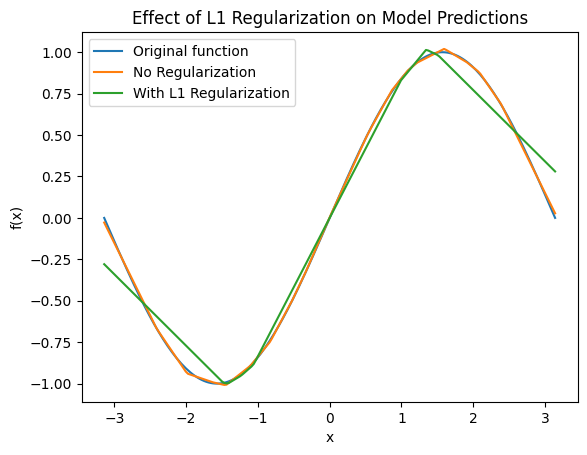

In [28]:
#visualization
with torch.no_grad():
    predictions_no_reg = model_no_reg(x).detach().numpy()
    predictions_with_reg = model_with_reg(x).detach().numpy()

plt.plot(x.numpy(), y.numpy(), label='Original function')
plt.plot(x.numpy(), predictions_no_reg, label='No Regularization')
plt.plot(x.numpy(), predictions_with_reg, label='With L1 Regularization')
plt.legend()
plt.title('Effect of L1 Regularization on Model Predictions')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

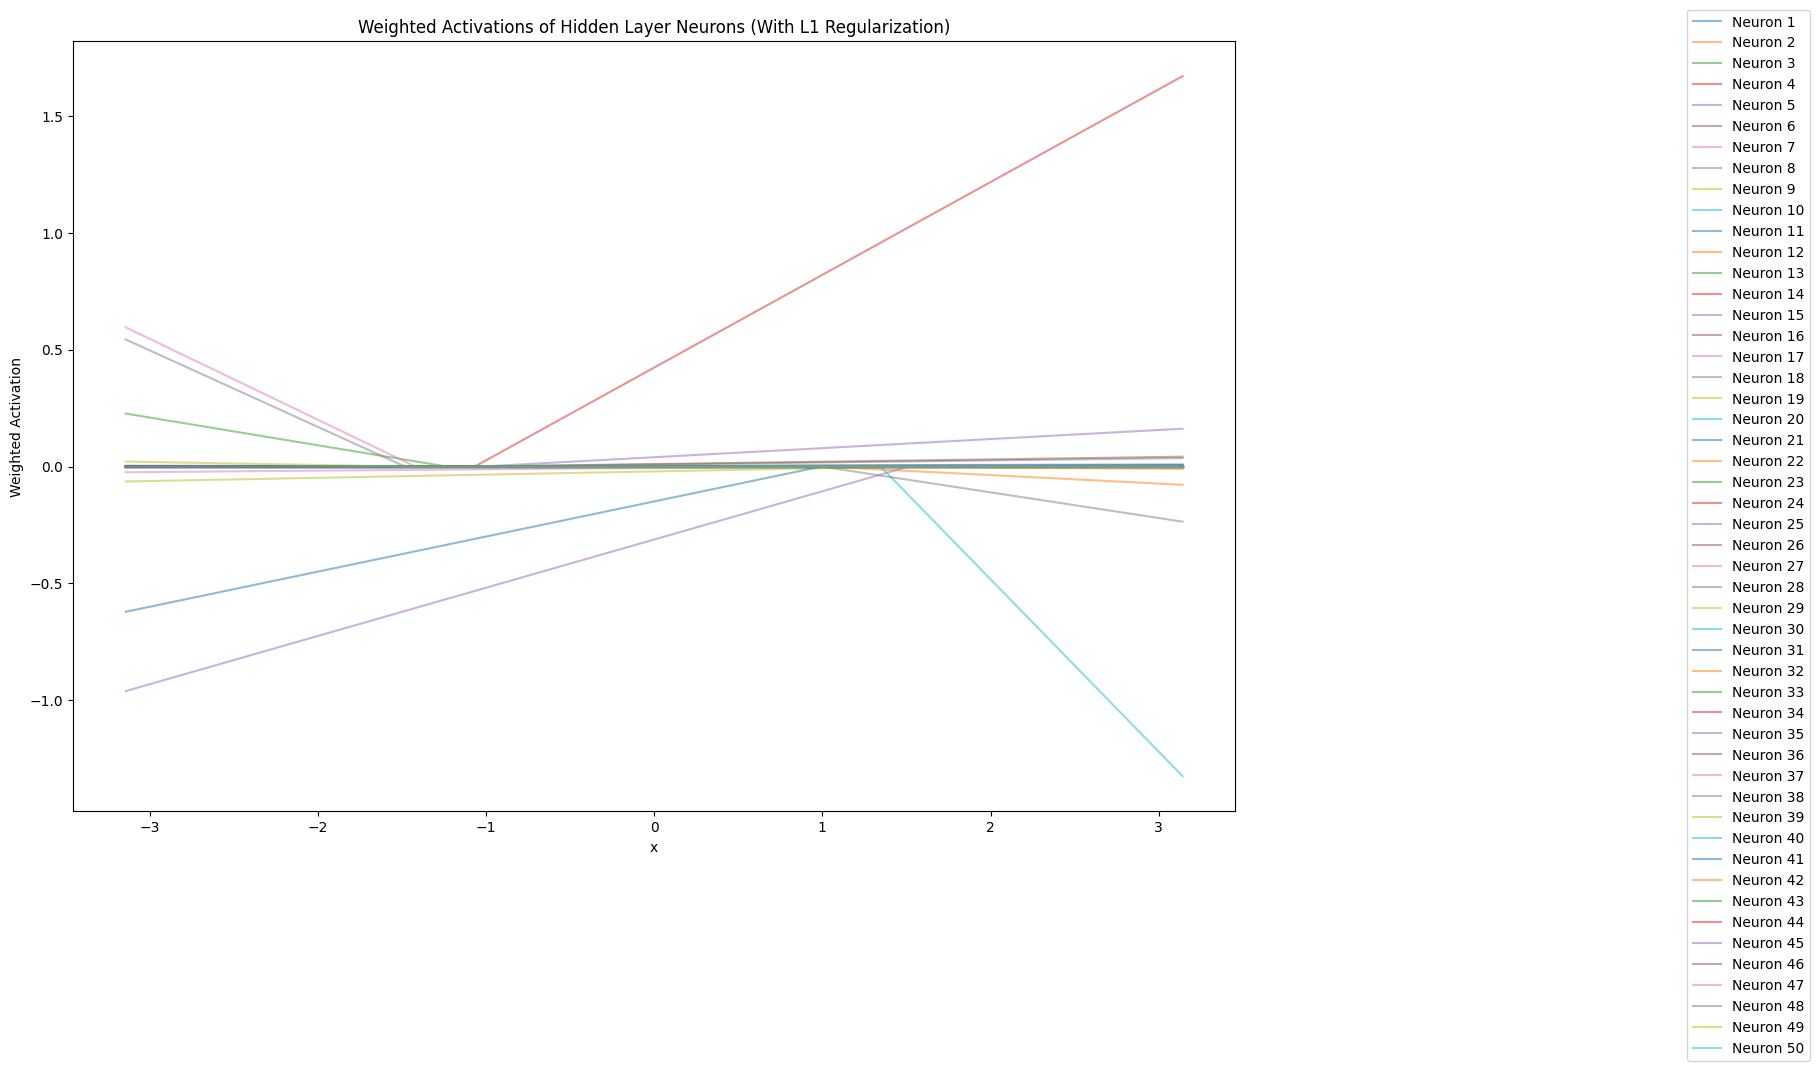

In [29]:
#visualize the contribution of each neuron
with torch.no_grad():
    _, activations_with_reg = model_with_reg.forward_with_activations(x)
weights_to_output_reg = model_with_reg.fc2.weight.detach()

# Compute weighted activations for the regularized model
weighted_activations_with_reg = activations_with_reg * weights_to_output_reg.T.view(-1)

plt.figure(figsize=(15, 10))
for i in range(weighted_activations_with_reg.size(1)):
    plt.plot(x.numpy(), weighted_activations_with_reg[:, i].detach().numpy(), alpha=0.5, label=f'Neuron {i+1}')

plt.title('Weighted Activations of Hidden Layer Neurons (With L1 Regularization)')
plt.xlabel('x')
plt.ylabel('Weighted Activation')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.05))
plt.show()

# 문제3

Lab 1 Universal Approximation Theorem에서 ReLU이외의 다른 activation
function으로 학습시켜보고 결과를 논의하세요.

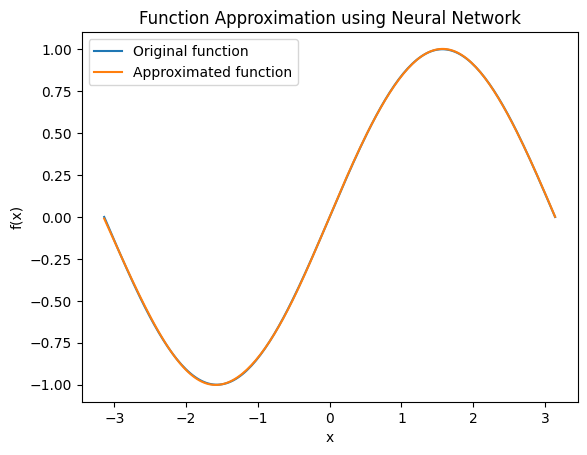

In [32]:
#기존코드
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Data generation
x = torch.linspace(-np.pi, np.pi, 200).view(-1, 1)
y = torch.sin(x)

# Neural network definition
class Net(nn.Module):
    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))  #바뀐 부분
        x = self.fc2(x)
        return x

# Model instantiation
model = Net(hidden_size=50)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 2000
for epoch in range(epochs):
    # Forward pass
    y_pred = model(x)
    loss = criterion(y_pred, y)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Results visualization
with torch.no_grad():
    predicted = model(x).detach().numpy()

# Original vs Approximated function plot
plt.plot(x.numpy(), y.numpy(), label='Original function')
plt.plot(x.numpy(), predicted, label='Approximated function')
plt.legend()
plt.title('Function Approximation using Neural Network')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()


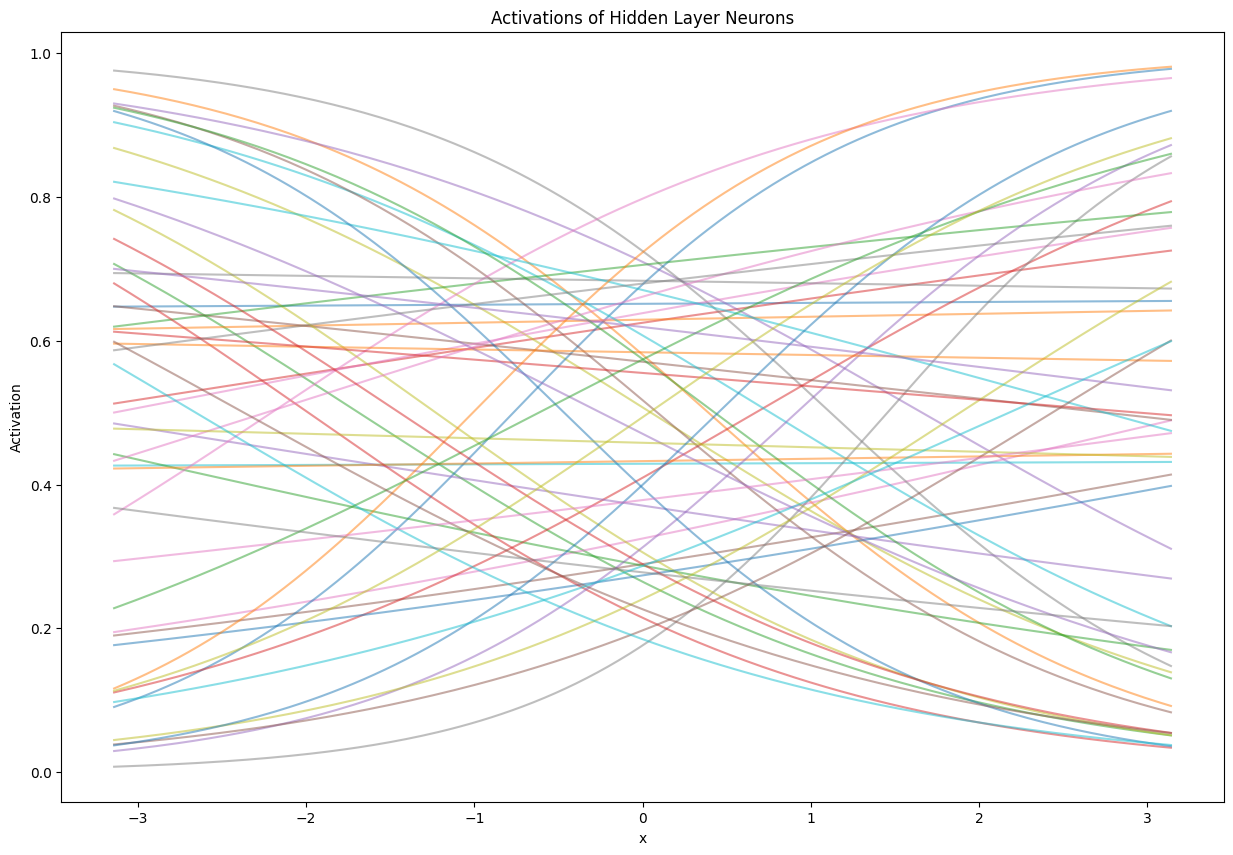

In [35]:
# Re-importing necessary libraries and re-defining classes and functions after reset
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Data generation
x = torch.linspace(-np.pi, np.pi, 200).view(-1, 1)

# Modified neural network definition for activation extraction
class NetWithActivations(Net):
    def __init__(self, hidden_size):
        super(NetWithActivations, self).__init__(hidden_size)

    def forward_with_activations(self, x):
        activations = torch.sigmoid(self.fc1(x))  #바뀐 부분
        output = self.fc2(activations)
        return output, activations

# Training setup
model = Net(hidden_size=50)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
y = torch.sin(x)
epochs = 2000
for epoch in range(epochs):
    y_pred = model(x)
    loss = criterion(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Extract activations
model_with_activations = NetWithActivations(hidden_size=50)
model_with_activations.load_state_dict(model.state_dict())

with torch.no_grad():
    _, activations = model_with_activations.forward_with_activations(x)

# Visualizing activations
plt.figure(figsize=(15, 10))
for i in range(activations.size(1)):  # For each neuron in the hidden layer
    plt.plot(x.numpy(), activations[:, i].numpy(), alpha=0.5)

plt.title('Activations of Hidden Layer Neurons')
plt.xlabel('x')
plt.ylabel('Activation')
plt.show()

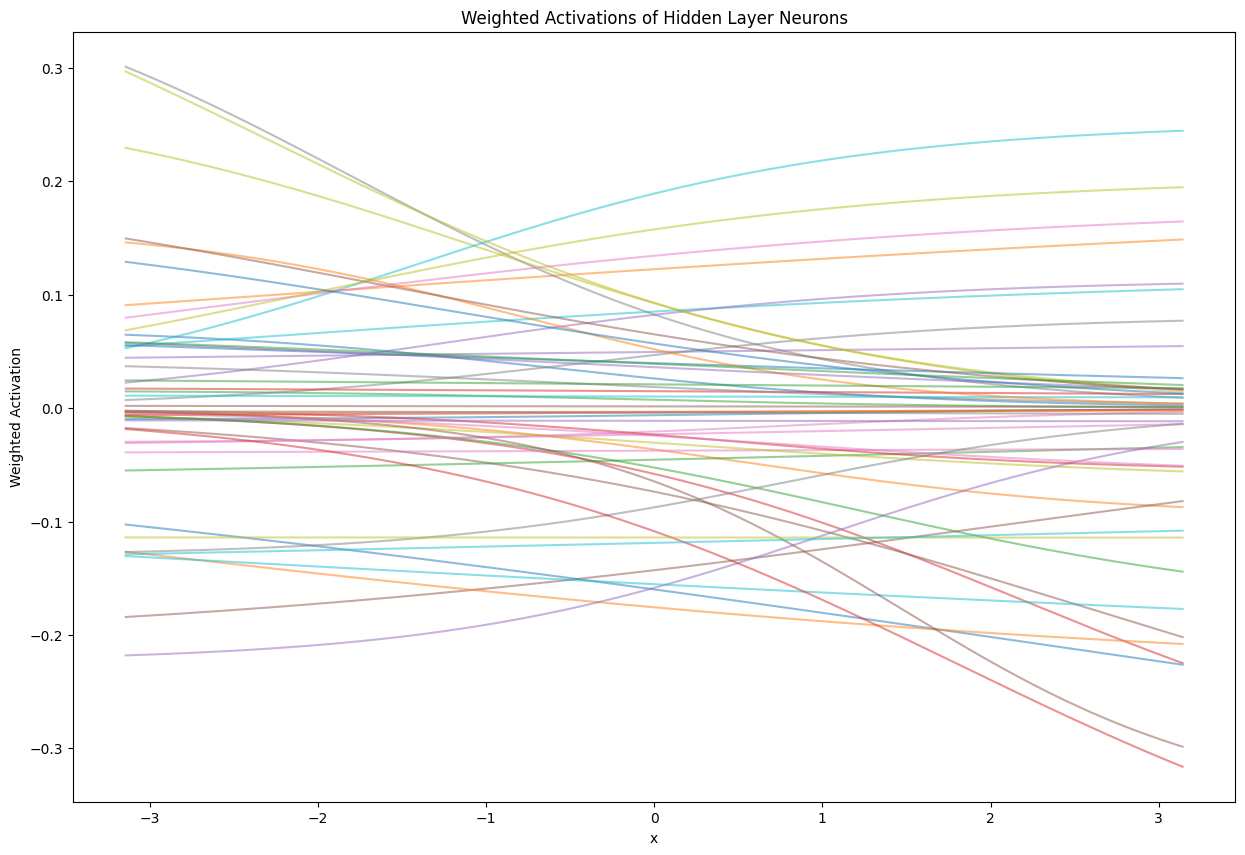

In [34]:

# Assuming model_with_activations is already defined and has the trained weights

with torch.no_grad():
    _, activations = model_with_activations.forward_with_activations(x)

# Get the weights from the hidden layer to the output
weights_to_output = model_with_activations.fc2.weight.detach()

# Compute weighted activations
weighted_activations = activations * weights_to_output

# Visualizing weighted activations
plt.figure(figsize=(15, 10))
for i in range(weighted_activations.size(1)):
    plt.plot(x.numpy(), weighted_activations[:, i].numpy(), alpha=0.5)

plt.title('Weighted Activations of Hidden Layer Neurons')
plt.xlabel('x')
plt.ylabel('Weighted Activation')
plt.show()

# 문제4

Lab 1 ANN for MNIST에서 모델을 hinge loss (SVM loss)로 학습시켜보고 결과를 논의하세요.

In [12]:
##바뀌기 전 ANN모델 - MNIST
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Loading the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Data loaders for the training and test set
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

# Define the MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)  # First layer (input to hidden)
        self.fc2 = nn.Linear(100, 10)     # Second layer (hidden to output)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = torch.relu(self.fc1(x))  # ReLU activation function
        x = self.fc2(x)  # No activation, output raw scores
        return x

# Training with Cross Entropy Loss
print("Training with Cross Entropy Loss:")
model = MLP()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

epochs = 10  # Run for 10 epochs
# Training loop
model.train()
for epoch in range(epochs):
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluation loop
model.eval()
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

accuracy = 100. * correct / len(test_loader.dataset)
print(f'Accuracy: {accuracy}%')

Training with Cross Entropy Loss:
Epoch 1, Loss: 0.04328953102231026
Epoch 2, Loss: 0.11700745671987534
Epoch 3, Loss: 0.038406260311603546
Epoch 4, Loss: 0.007075862493366003
Epoch 5, Loss: 0.0098114600405097
Epoch 6, Loss: 0.03637365251779556
Epoch 7, Loss: 0.03234659507870674
Epoch 8, Loss: 0.05626329779624939
Epoch 9, Loss: 0.0656542256474495
Epoch 10, Loss: 0.03315075486898422
Accuracy: 97.67%


# 문제5

Lab 1 ANN for MNIST에서 모델을 nn module이 아닌 barebone function만으로 같은 기능을 구현하세요.

In [28]:
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Loading the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Data loaders for the training and test set
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

class ThreeLayerNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_size =28*28
    self.hidden_size=512
    self.output_size=10

    #Initialize weights and biases for linear layers
    self.flatten = nn.Flatten()
    self.weight1 = torch.rand(self.hidden_size, self.input_size, requires_grad=True)
    self.bias1= torch.rand(self.hidden_size, requires_grad=True)
    self.weight2 = torch.rand(self.hidden_size, self.hidden_size, requires_grad=True)
    self.bias2 = torch.rand(self.hidden_size, requires_grad=True)
    self.weight3 = torch.rand(self.output_size, self.hidden_size, requires_grad=True)
    self.bias3 = torch.rand(self.output_size, requires_grad=True)


  def forward(self, x):
    x = self.flatten(x)
    x = F.relu(F.linear(x, self.weight1, self.bias1))
    x = F.relu(F.linear(x, self.weight2, self.bias2))
    logits = F.linear(x, self.weight3, self.bias3)
    return logits

model = ThreeLayerNN()
optimizer = optim.SGD([model.weight1, model.bias1, model.weight2, model.bias2, model.weight3, model.bias3]
                      , lr=0.01, momentum=0.9)

#define cross_entropy_loss function
def cross_entropy_loss(output, target):
    loss = -torch.mean(target * torch.log(F.softmax(output, dim=1) + 1e-7))
    return loss

epochs = 10  # Run for 10 epochs
# Training loop
model.train()
for epoch in range(epochs):
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = cross_entropy_loss(output, F.one_hot(target, num_classes=10).float())
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 1.5110715627670288
Epoch 2, Loss: 1.5110714435577393
Epoch 3, Loss: 1.5614404678344727
Epoch 4, Loss: 1.5614405870437622
Epoch 5, Loss: 1.5110714435577393
Epoch 6, Loss: 1.5614405870437622
Epoch 7, Loss: 1.4103333950042725
Epoch 8, Loss: 1.5110714435577393
Epoch 9, Loss: 1.3095953464508057
Epoch 10, Loss: 1.4607025384902954


# 문제6

다음 x와 w의 matrix multiplication을 수행하고자 할 때, GPU 사용과 CPU 사용시 수행시간을 비교하세요.

x = torch.rand(512, 4096)

w = torch.rand(4096, 4096)

In [52]:
#cpu 사용시 수행시간 측정

import torch
import time

x = torch.rand(512, 4096)
w = torch.rand(4096, 4096)

mul = torch.matmul(x, w)
print(mul)

start_time = time.time()

# 작업 코드

end_time = time.time()

print('코드 실행 시간: %.10fs' % (end_time - start_time))

tensor([[1007.3775, 1010.2863, 1033.7133,  ..., 1028.4503, 1040.7816,
         1025.9241],
        [1012.0531, 1018.9213, 1040.1838,  ..., 1035.7284, 1038.5616,
         1028.7057],
        [1017.6069, 1013.6195, 1040.5819,  ..., 1036.8425, 1044.8857,
         1024.1428],
        ...,
        [ 997.1069,  996.0208, 1035.1121,  ..., 1009.8418, 1027.6709,
         1013.8080],
        [1011.6970, 1018.7439, 1055.9752,  ..., 1033.4918, 1041.1846,
         1039.8480],
        [1013.0822, 1000.5327, 1036.7748,  ..., 1021.6657, 1027.1823,
         1020.0378]])
코드 실행 시간: 0.0000545979s


In [1]:
#gpu 사용시 수행시간 측정

import torch
import time

x = torch.rand(512, 4096)
w = torch.rand(4096, 4096)

mul = torch.matmul(x, w)
print(mul)

start_time = time.time()


end_time = time.time()

print('코드 실행 시간: %.10fs' % (end_time - start_time))

tensor([[1028.6075, 1018.9771, 1023.8374,  ..., 1009.8655, 1020.5826,
         1020.3588],
        [1046.4719, 1024.7914, 1048.8594,  ..., 1017.4711, 1035.6301,
         1031.5546],
        [1030.6215, 1006.8734, 1032.0702,  ..., 1006.7766, 1021.5345,
         1014.6678],
        ...,
        [1024.6057,  993.0896, 1011.3510,  ...,  991.7759, 1011.3881,
         1005.7327],
        [1026.4808, 1007.9581, 1033.6342,  ..., 1004.6572, 1015.0267,
         1025.9423],
        [1029.2511, 1014.5236, 1043.0947,  ..., 1020.5015, 1023.4783,
         1017.9824]])
코드 실행 시간: 0.0000498295s


# 문제 7

수업에서 설명한 Logistic Regression (Linear Classifier)과 ANN으로 각각 CIFAR10 데이터를 학습시키고 이미지와 곱해지는 weight들을 이미지 형태로 시각화 하여 비교하세요.

In [1]:
#CIFAR10 불러오기 + 정규화하기
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

# Loading the MNIST dataset
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./data', train=False, transform=transform)

# Data loaders for the training and test set
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 63888718.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


# 문제7 Logistic regression




In [21]:
#CIFAR10 불러오기 + 정규화하기
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

# Loading the MNIST dataset
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./data', train=False, transform=transform)

# Data loaders for the training and test set
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#Logistic Regression(Linear Classifier)
# Define model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)
        out = self.linear(x)
        return out

input_size = 3 * 32 * 32  # CIFAR-10 images are 32x32x3
num_classes = 10

model = LogisticRegression(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy-logistic regression: %d %%' % (
    100 * correct / total))

Finished Training
Accuracy-logistic regression: 38 %


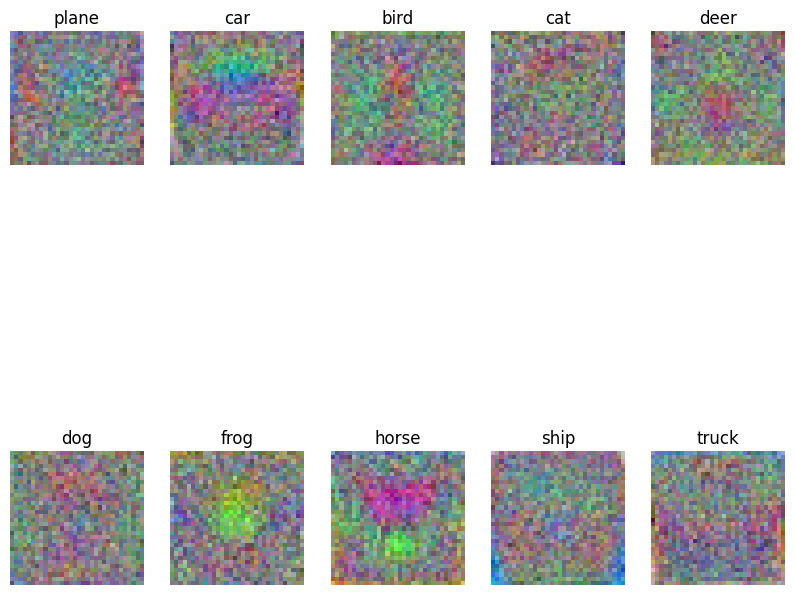

In [23]:
import matplotlib.pyplot as plt

# Get the weights of the logistic regression model
weights = model.linear.weight.data

# Reshape and normalize weights for visualization
weights_img = weights.view(10, 3, 32, 32)  # Reshape weights to image shape
weights_img = (weights_img - weights_img.min()) / (weights_img.max() - weights_img.min())  # Normalize to [0, 1]

# Plot the weights
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(weights_img[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title(classes[i])
plt.show()

# 문제7 ANN model

In [24]:
#CIFAR10 불러오기 + 정규화하기
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

# Loading the MNIST dataset
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./data', train=False, transform=transform)

# Data loaders for the training and test set
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Define ANN model
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define loss function and optimizer
model2 = ANN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001, weight_decay = 0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # Forward pass
        outputs = model2(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy-ANN: %d %%' % (100 * correct / total))

Files already downloaded and verified
Finished Training
Accuracy-ANN: 52 %


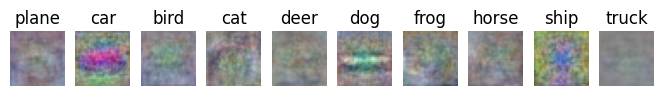

In [25]:
import matplotlib.pyplot as plt

# Get the weights of the first linear layer
first_layer_weights = model2.fc1.weight.data

# Reshape and normalize weights for visualization
weights_img = first_layer_weights.view(120, 3, 32, 32)  # Reshape weights to image shape
weights_img = (weights_img - weights_img.min()) / (weights_img.max() - weights_img.min())  # Normalize to [0, 1]

# Plot the weights
plt.figure(figsize=(10, 10))
for i in range(len(classes)):
    plt.subplot(10, 12, i + 1)
    plt.imshow(weights_img[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title(classes[i])
plt.show()